## vgg16 feature extraction evaluation with temporal clustering

In [1]:
%pylab inline
%load_ext autoreload
%autoreload 2

import os
import sys
sys.argv=['']
sys.path.append('/nethome/jbang36/eva_storage')


import numpy as np
#import utils.helpers as helpers
import utils as helpers
from loaders.uadetrac_loader import UADetracLoader
from eva_storage.preprocessingModule import PreprocessingModule
from eva_storage.UNet import UNet
from eva_storage.clusterModule import ClusterModule
from filters.minimum_filter import FilterMinimum


Populating the interactive namespace from numpy and matplotlib


In [2]:
from eva_storage.sampling_experiments.temporal_clustering_evaluation import *

In [3]:
total_eval_num = 2000

#loader = JacksonLoader()
#images = loader.load_images()
#labels = loader.load_labels(relevant_classes=JACKSON_CLASSES)
#images, labels = loader.filter_input(images, labels)
#boxes = create_dummy_boxes(labels)
#labelmap = JACKSON_CLASSES

loader = UADetracLoader()
images = loader.load_images(dir='/nethome/jbang36/eva_storage/data/ua_detrac/test_images')
test_labels, test_boxes = loader.load_labels(dir='/nethome/jbang36/eva_storage/data/ua_detrac/test_xml')
labels = test_labels['vehicle']
images, labels, boxes = loader.filter_input3(images, labels, test_boxes)
labelmap = UAD_CLASSES


06-03-2020 03:56:10 [info:049]INFO : Total time to load 22481 images: 171.02962896879762 (sec)


In [54]:
### examine the contents of the dataset


def draw_multiple_images(images):
    w=10
    h=10
    size = 20
    fig=plt.figure(figsize=(size, size))
    columns = 4
    rows = 5
    for i in range(1, columns*rows +1):
        #img = np.random.randint(10, size=(h,w))
        fig.add_subplot(rows, columns, i)
        plt.imshow(images[i])
    plt.show()



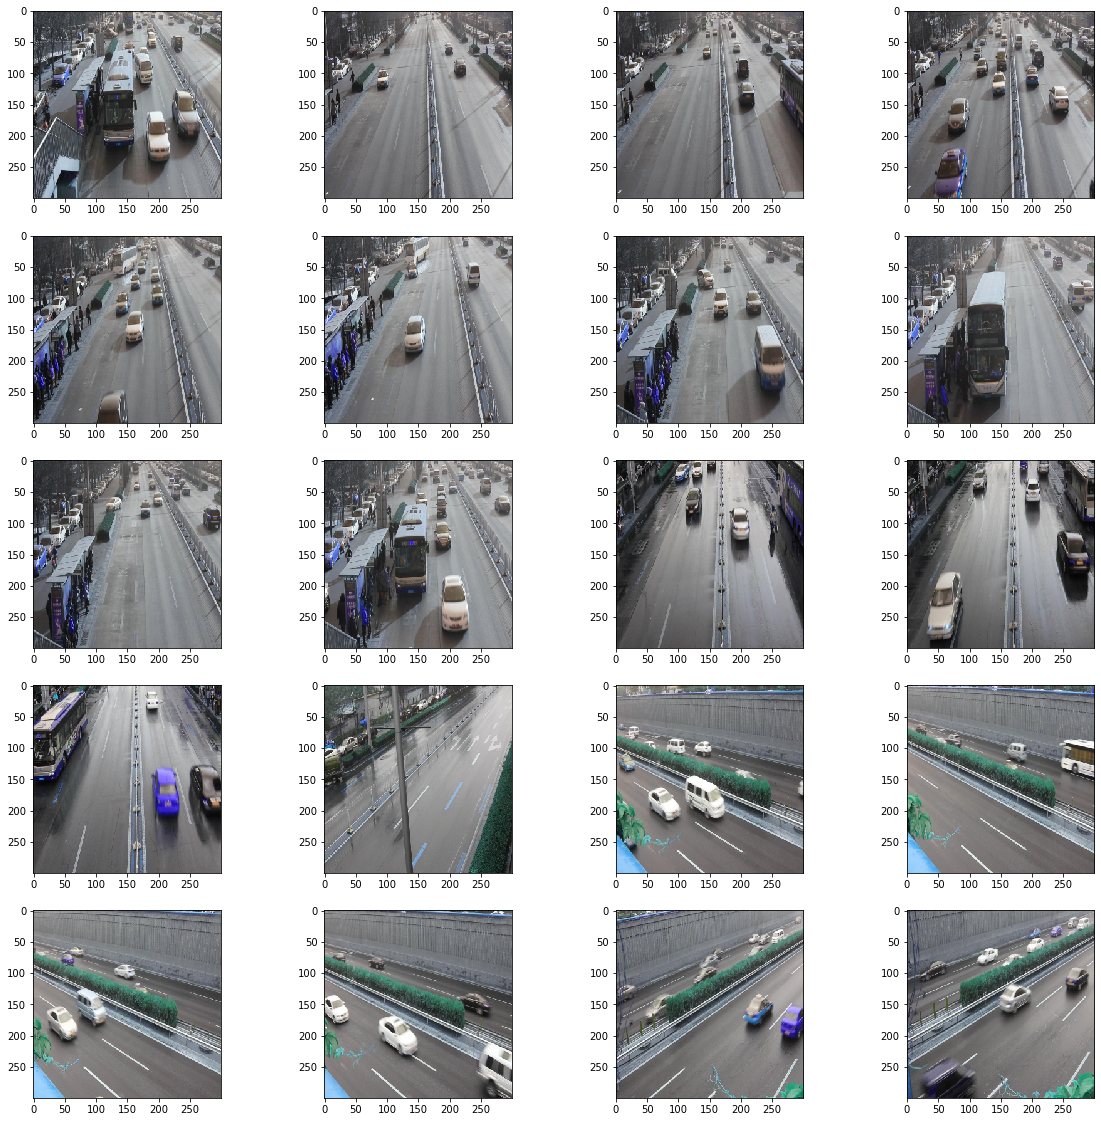

In [56]:
draw_multiple_images(images[::1000])

In [57]:
images__ = images_reshaped.reshape(len(images_reshaped), 10, 10)

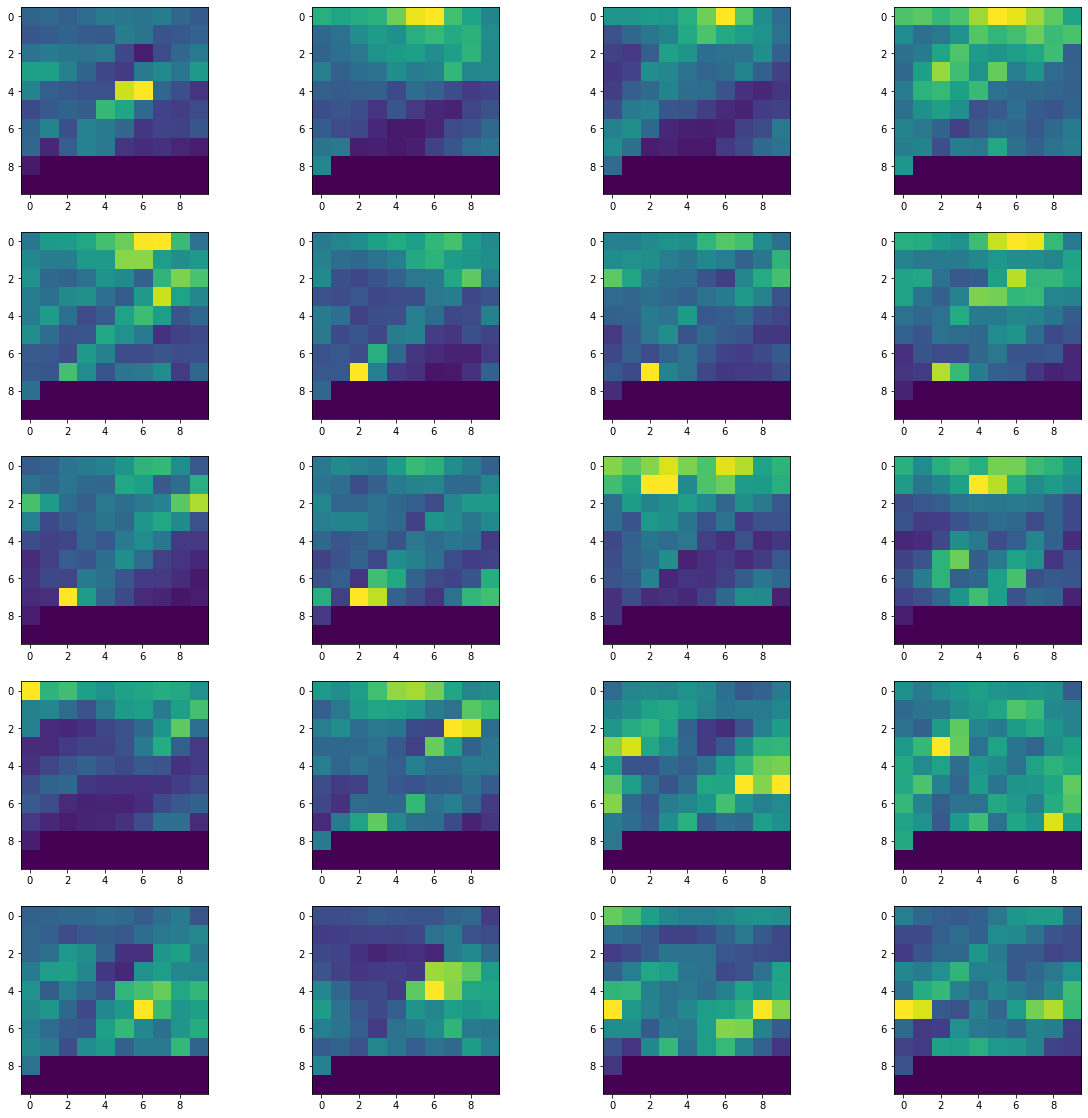

In [58]:
draw_multiple_images(images__[::1000])

In [4]:
## we need to debug again, we keep getting GPU failures

In [5]:
import torchvision.models as models

In [6]:
vgg16 = models.vgg16(pretrained = True)
vgg16.cuda()



VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (17): Conv2d

In [7]:
torch.set_default_tensor_type('torch.FloatTensor')

In [66]:
## does the pytorch model vgg16 output differ depending on the input size?

test_image = np.copy(images[0])
test_image = test_image[::2, ::2, :]
print(test_image.shape)
test_image_torch = torch.Tensor(test_image).cuda()
test_image_torch = test_image_torch.unsqueeze(0)
test_image_torch = test_image_torch.permute(0,3,1,2)
test_output = vgg16.features(test_image_torch)

(150, 150, 3)


In [67]:
test_output_np = test_output.cpu().detach().numpy()

In [68]:
test_output_np.shape

(1, 512, 4, 4)

In [8]:
images_torch = torch.Tensor(images)
images_torch = images_torch.permute(0, 3, 1, 2)
data_loader = torch.utils.data.DataLoader(images_torch, batch_size = 32, shuffle = False)
outputs = []


In [9]:
images_torch.is_cuda

False

In [10]:
for i, data_pack in enumerate(data_loader):
    image_batch = data_pack
    image_batch = image_batch.cuda()
    output = vgg16.features(image_batch)
    output = output.cpu()
    output_np = output.detach().numpy()
    outputs.append( np.sum(output_np, axis = 1))



In [11]:
### it successfully does the whole thing!!
len(outputs)

697

In [12]:
outputs[0].shape

(32, 9, 9)

In [13]:
images_reshaped = np.concatenate(outputs, axis = 0)
images_reshaped = images_reshaped.reshape(images_reshaped.shape[0], images_reshaped.shape[1] * images_reshaped.shape[2])


In [16]:
desired_vector_size = 100

In [17]:
if images_reshaped.shape[1] > desired_vector_size:
    images_reshaped = images_reshaped[:,:desired_vector_size]

elif images_reshaped.shape[1] < desired_vector_size:
    tmp = np.ndarray(shape = (images_reshaped.shape[0], desired_vector_size - images_reshaped.shape[1]))
    images_reshaped = np.concatenate([images_reshaped, tmp], axis = 1)

In [18]:
images_reshaped.shape

(22277, 100)

In [23]:
total_eval_num = 100

In [24]:

###configure the gpu
#import os
#os.environ["CUDA_VISIBLE_DEVICES"] = "1"  ## we want to run everything on gpu 1

## we want to filter out only the ones that we want to use

st = time.perf_counter()

cluster_count = total_eval_num
number_of_neighbors = 3

#feature_extraction_method = DownSampleMeanMethod()
feature_extraction_method = VGG16Method()
rep_selection_method = MeanEncounterMethod()
temporal_cluster = TemporalClusterModule(downsample_method=feature_extraction_method, sampling_method=rep_selection_method)
_, rep_indices, all_cluster_labels = temporal_cluster.run(images, number_of_clusters=cluster_count,
                                                          number_of_neighbors=number_of_neighbors)


06-03-2020 06:14:09 [info:049]INFO : Cluster module starting....
06-03-2020 06:16:51 [info:049]INFO : Time to fit 22277: 161.60385150648654 (sec)
06-03-2020 06:16:51 [info:049]INFO : Sampling frames based on Mean Encounter Method -- we search for frame that is closest to centroid of the cluster strategy


In [26]:
## we need to get rep labels, rep_boxes as well
rep_images = images[rep_indices]
rep_labels = np.array(labels)[rep_indices]
rep_boxes = np.array(boxes)[rep_indices]

mapping = temporal_cluster.get_mapping(rep_indices, all_cluster_labels)
mapping = mapping.astype(np.int)


print(f"total eval num: {total_eval_num}")
print(f"finished whole process in {time.perf_counter() - st} (secs)")
print(f"Feature Extraction: {temporal_cluster.downsample_method}")
print(f"Sampling Method: {temporal_cluster.sampling_method}")

predicted_labels, gt_labels = evaluate_with_gt(images, labels, boxes, rep_images, rep_labels, rep_boxes, mapping, labelmap)

print("\n\n")

total eval num: 100
finished whole process in 414.6689531086013 (secs)
Feature Extraction: Extract the features using vgg16 network
Sampling Method: Mean Encounter Method -- we search for frame that is closest to centroid of the cluster
hello world
car, type of key <class 'str'>
bus, type of key <class 'str'>
others, type of key <class 'str'>
van, type of key <class 'str'>
key: car, score: 0.9798895722045159
key: bus, score: 0.4990348790232078
key: others, score: 0.5375050500516227
key: van, score: 0.5336894554922117





In [28]:
### let's examine the samples 

predicted_bus = predicted_labels['bus']
gt_bus = gt_labels['bus']

In [39]:
image98 = images_reshaped[all_cluster_labels == 98]

In [50]:
indices_98 = all_cluster_labels == 98

for i in range(len(indices_98)):
    if indices_98[i]:
        print(i)

6187


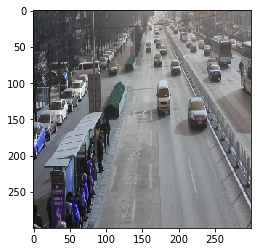

In [51]:
plt.imshow(images[6187])

In [52]:
indices_99 = all_cluster_labels == 99

for i in range(len(indices_99)):
    if indices_99[i]:
        print(i)

6801


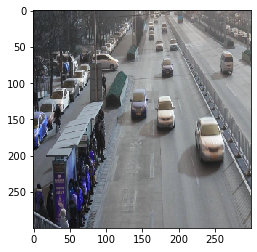

In [53]:
plt.imshow(images[6801])

In [40]:
image98.shape

(1, 100)

In [42]:
image99 = images_reshaped[all_cluster_labels == 99]

In [43]:
image98 = image98.reshape(10,10)
image99 = image99.reshape(10,10)

In [46]:
image0 = images_reshaped[all_cluster_labels == 0]

In [47]:
image0.shape

(13, 100)

In [48]:
image0 = image0[0]
image0 = image0.reshape(10,10)

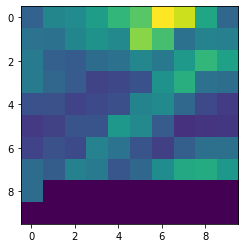

In [49]:
plt.imshow(image0)

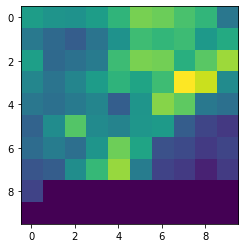

In [44]:
plt.imshow(image98)

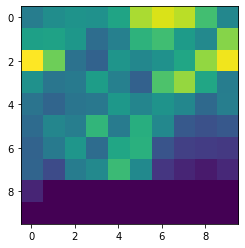

In [45]:
plt.imshow(image99)

In [30]:
gt_bus[:100]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [33]:
from eva_storage.analysis.sampling_analysis_tools import *



In [34]:
df = accuracy_by_cluster(predicted_labels, gt_labels, all_cluster_labels)

In [38]:
df[30:]

,size,car,bus,others,van
30,596.0,1.0,0.783557,1.0,0.42953
31,4.0,1.0,1.000000,1.0,1.00000
32,4.0,1.0,1.000000,1.0,1.00000
33,1.0,1.0,1.000000,1.0,1.00000
34,4.0,1.0,1.000000,1.0,1.00000
35,3.0,1.0,1.000000,1.0,1.00000
36,3.0,1.0,1.000000,1.0,1.00000
37,4.0,1.0,1.000000,1.0,1.00000
38,1.0,1.0,1.000000,1.0,1.00000
39,98.0,1.0,0.724490,1.0,1.00000
